Here we install required packages into the Jupyter environment. This step is required only once. 

In [ ]:
#!pip2 install tables --quiet
#!pip2 install neo --quiet
#!pip2 install elephant --quiet

In [5]:
import neo
import elephant
import quantities as pq
import numpy as np

Define the path names. 

In [6]:
from os.path import join
import imp
#client = get_bbp_client().document
COLLAB_PATH = 'home/robin/HBP/Projects/NEST_SpiNNaker_comparison'
COLLAB_PATH_NEST = COLLAB_PATH + "/results/NEST_data"
COLLAB_PATH_SPINNAKER = COLLAB_PATH + "/results/SpiNNaker_data"

plotting_path = './plotting_functions.py'
#client.download_file(join(COLLAB_PATH, 'plotting_functions.py'), plotting_path)
plotting = imp.load_source('*', plotting_path)

## Auxiliary Functions
### Loading NEST and SpiNNaker data using NeoHDF5IO
The following are two functions to load the NEST and SpiNNaker data. The HBP client is used to download the data files from the storage and Neo is used to read in the data. 

In [3]:
def load_data_NEST(path,file_name_list,N):
    spike_train_list = []
    for file_name in file_name_list:
        # exc. and inh. as tuples, layerwise
        nest_data_path_exc = './'+file_name+'E.h5'
        nest_data_path_inh = './'+file_name+'I.h5'
        #client.download_file(path+'/'+file_name+'E.h5', nest_data_path_exc)
        #client.download_file(path+'/'+file_name+'I.h5', nest_data_path_inh)
        data = (neo.io.NeoHdf5IO(path + nest_data_path_exc), 
                neo.io.NeoHdf5IO(path + nest_data_path_inh))
        spiketrains = (data[0].read_block().list_children_by_class(neo.SpikeTrain),
                       data[1].read_block().list_children_by_class(neo.SpikeTrain))
        tstart = spiketrains[0][0].t_start
        tstop = spiketrains[0][0].t_stop
        unit = spiketrains[0][0].units
        # if the recorded spiketrains are less than number of samples
        while len(spiketrains[0])<N:
            spiketrains[0].append(neo.SpikeTrain([]*unit,t_start=tstart, t_stop=tstop))
        while len(spiketrains[1])<N:
            spiketrains[1].append(neo.SpikeTrain([]*unit,t_start=tstart, t_stop=tstop))
        spike_train_list.append(spiketrains)
    return spike_train_list


def load_data_SpiNNaker(path,file_name_list,N):
    spike_train_list = []
    for file_name in file_name_list:
        # exc. and inh. as tuples
        spinnaker_data_path_exc = './'+'Spinnaker_'+file_name+'E.h5'
        spinnaker_data_path_inh = './'+'Spinnaker_'+file_name+'I.h5'
        client.download_file(path+'/'+file_name+'E.h5', spinnaker_data_path_exc)
        client.download_file(path+'/'+file_name+'I.h5', spinnaker_data_path_inh)
        data = (neo.io.NeoHdf5IO(spinnaker_data_path_exc), 
                neo.io.NeoHdf5IO(spinnaker_data_path_inh))
        seg = (data[0].read_segment(), data[1].read_segment())
        spiketrains = (seg[0].segments[0].spiketrains[:N],
                       seg[1].segments[0].spiketrains[:N])
        spike_train_list.append(spiketrains)
    return spike_train_list

Here we now use the two function to read the data of excitatory and inhibitory neurons from layers 2/3, 4, 5 and 6. 

In [7]:
#neo.io.NeoHdf5IO('~/HBP/Projects/NEST_SpiNNaker_comparison/spikes_L4E.h5')
#neo.io.NeoHdf5IO.readable_objects
import os
from neo.io.hdf5io import NeoHdf5IO
import tables
cwd = os.getcwd()
filename = cwd + '/spikes_L4E.h5'
print filename
file = NeoHdf5IO(filename=filename)
print file

/home/robin/HBP/Projects/NEST_SpiNNaker_comparison/spikes_L4E.h5


NameError: Incorrect file path, couldn't find or create a file.

In [7]:
file_names = ["spikes_L23", "spikes_L4", "spikes_L5", "spikes_L6"]

# Number of spiketrains to load
N = 100

sts_NEST = load_data_NEST(
    COLLAB_PATH_NEST, [f for f in file_names], N)
sts_SPINNAKER = load_data_SpiNNaker(
    COLLAB_PATH_SPINNAKER, [f for f in file_names], N)

NameError: Incorrect file path, couldn't find or create a file.

## Raster plot
Calculate population histogram and mean firing rate

In [15]:
from elephant.statistics import time_histogram
from elephant.statistics import mean_firing_rate


# Binsize for histogram
binsize = 2 * pq.ms

# Population histogram and mean firing rate
pophist_NEST = []
mean_rate_NEST = []
for sts_NEST_layer in sts_NEST:
    pophist_NEST.append((time_histogram(sts_NEST_layer[0],binsize),time_histogram(sts_NEST_layer[1], binsize)))
    mean_rate_NEST.append(([mean_firing_rate(st).rescale('Hz') for st in sts_NEST_layer[0]],
                          [mean_firing_rate(st).rescale('Hz') for st in sts_NEST_layer[1]]))

pophist_SPINNAKER = []
mean_rate_SPINNAKER = []
for sts_SPINNAKER_layer in sts_SPINNAKER:
    pophist_SPINNAKER.append((time_histogram(sts_SPINNAKER_layer[0],binsize),
                              time_histogram(sts_SPINNAKER_layer[1], binsize)))
    mean_rate_SPINNAKER.append(([mean_firing_rate(st).rescale('Hz') for st in sts_SPINNAKER_layer[0]],
                                [mean_firing_rate(st).rescale('Hz') for st in sts_SPINNAKER_layer[1]]))

Plot the raster plots of NEST and SpiNNaker side by side. 

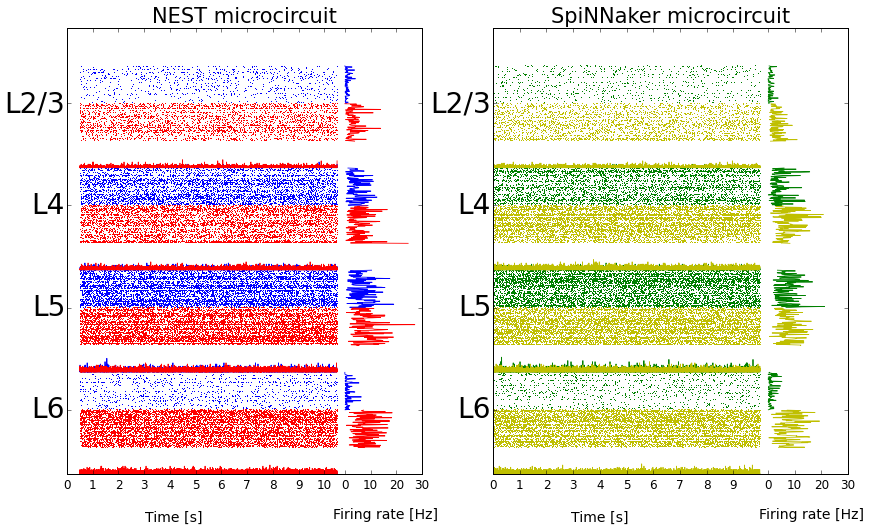

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
layers = ['L6' ,'L5','L4', 'L2/3']
plt.figure(figsize = (14,8))
ax = plt.subplot(1,2,1)
plotting.plot_raster_pophist_rate(ax,
    sts_NEST, pophist_NEST, mean_rate_NEST,binsize,N,\
    layers,'NEST',['b','r'],14)
ax = plt.subplot(1,2,2)
plotting.plot_raster_pophist_rate(ax,
    sts_SPINNAKER, pophist_SPINNAKER, mean_rate_SPINNAKER,binsize,N,\
    layers,'SpiNNaker',['g','y'],14)

Calculate CV and ISI

In [17]:
from elephant.statistics import cv, isi

cv_NEST = []
for sts_NEST_layer in sts_NEST:
    cv_NEST.append(([cv(isi(i)) for i in sts_NEST_layer[0]],
                    [cv(isi(i)) for i in sts_NEST_layer[1]]))
    
cv_Spinnaker = [] 
for sts_spinnaker_layer in sts_SPINNAKER:
    cv_Spinnaker.append(([cv(isi(i)) for i in sts_spinnaker_layer[0]],
                         [cv(isi(i)) for i in sts_spinnaker_layer[1]]))
    
for idx_layer, (n_layer, s_layer) in enumerate(zip(cv_NEST, cv_Spinnaker)):
    for idx, (n, s) in enumerate(zip(n_layer, s_layer)):
        for ii, (ne, si) in enumerate(zip(n, s)):
            if isinstance(ne, np.ndarray):
                cv_NEST[idx_layer][idx][ii] = np.nan
            if isinstance(si, np.ndarray):
                cv_Spinnaker[idx_layer][idx][ii] = np.nan

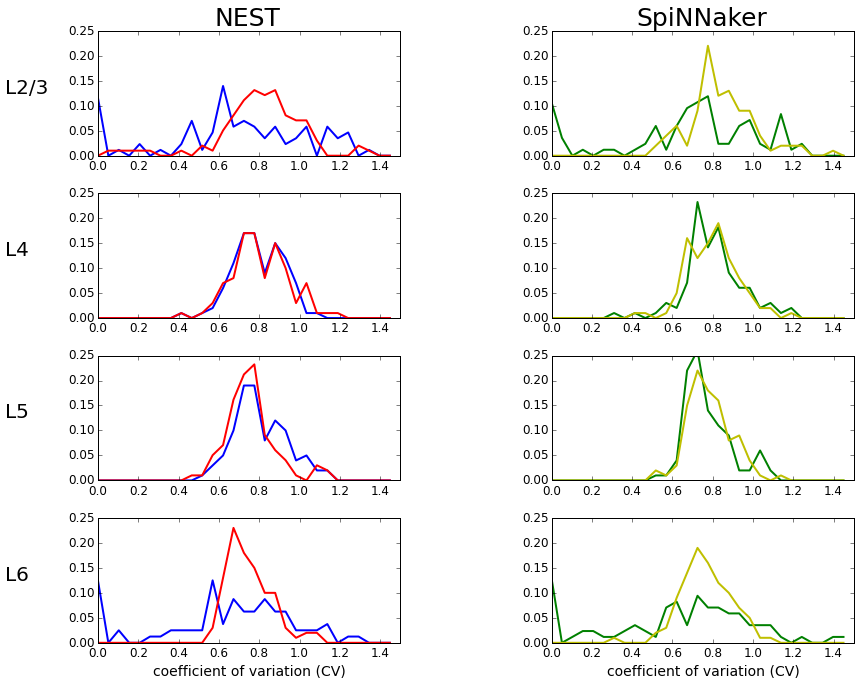

In [18]:
plt.figure(figsize = (14,10)) 
plotting.plot_distribution_comparison(cv_NEST, cv_Spinnaker, np.linspace(0,1.5,30),layers[::-1],['NEST','SpiNNaker'],
                 ['b','r'],['g','y'],20,(0,1.5),(0,0.25),'coefficient of variation (CV)')

Calculate the pearson correlation coefficient

In [23]:
from elephant.spike_train_correlation import corrcoef
from elephant.conversion import BinnedSpikeTrain
corr_NEST = []
corr_Spinnaker = [] 
binsize = 2*pq.ms
bins_histogram = np.linspace(-0.03,0.03,100)

for sts_NEST_layer in sts_NEST:
    binned_st = (BinnedSpikeTrain(sts_NEST_layer[0],binsize),
                 BinnedSpikeTrain(sts_NEST_layer[1],binsize))
    corr_mat = (corrcoef(binned_st[0]), corrcoef(binned_st[1]))
    corr_NEST.append((corr_mat[0][np.triu_indices(len(corr_mat[0]),1)],
                       corr_mat[1][np.triu_indices(len(corr_mat[1]),1)]))
                     
for sts_spinnaker_layer in sts_SPINNAKER:
    binned_st = (BinnedSpikeTrain(sts_spinnaker_layer[0],binsize),
                 BinnedSpikeTrain(sts_spinnaker_layer[1],binsize))
    corr_mat = (corrcoef(binned_st[0]), corrcoef(binned_st[1]))
    corr_Spinnaker.append((corr_mat[0][np.triu_indices(len(corr_mat[0]),1)],
                           corr_mat[1][np.triu_indices(len(corr_mat[1]),1)]))

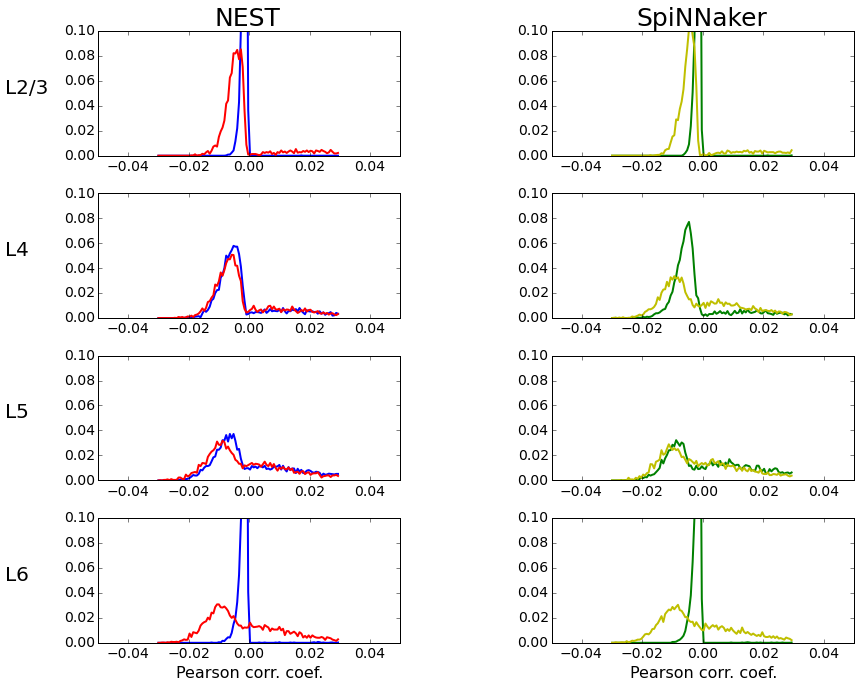

In [32]:
plt.figure(figsize = (14,10))
plotting.plot_distribution_comparison(corr_NEST,corr_Spinnaker,bins_histogram,layers[::-1],['NEST','SpiNNaker'],
                 ['b','r'],['g','y'],20,(-0.05,0.05),(0,0.1),'Pearson corr. coef.')